# Plotter for swag predictions
This notebook is used to experiment on how to plot predicted uncertainity

In [1]:
import sys
sys.path.append('..')

import seisbench.generate as sbg
import seisbench.models as sbm

from seisbench.data import WaveformDataset
from seisbench.models import EQTransformer
from seisbench.util import worker_seeding

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
import torch
from torch.utils.data import DataLoader

import pandas as pd
from utils.utils import preprocess, predict, annotate_window_post


In [2]:
batch_size = 1000 #
num_workers = 24  # The number of threads used for loading data

data = WaveformDataset("/data/STEAD_dataset/.seisbench/datasets/stead/")

train_loader, dev_loader, test_loader = preprocess(data, batch_size, num_workers)


In [24]:
from swag.posteriors import SWAG

dataset = test_loader.dataset

# Load model
weights = torch.load('../../results/trained_models/eqt_normal/swag-20.pt')['state_dict']
model = SWAG(
        EQTransformer,
        no_cov_mat=True,
        max_num_models=20,
        in_channels= 1
    )
model.load_state_dict(state_dict=weights, strict=False)
model.cuda()

model.sample(0.0)

preds = []

for i in range(3):
  # Get a random sample
  random_index = int(np.random.random()*len(dataset))
  sample = dataset[random_index]

  preds_p = []
  preds_p_picks = []
  preds_s = []
  preds_s_picks = []
  preds_det = []

  # Predict
  for i in range(200):
    sample_input = sample['X'][:1,:]
    output = model(torch.tensor(sample_input, device='cuda').unsqueeze(0))
    preds_p.append(output[1].detach().cpu().numpy()[0])
    preds_p_picks.append(np.nanargmax(annotate_window_post(preds_p[-1])))
    preds_s.append(output[2].detach().cpu().numpy()[0])
    preds_s_picks.append(np.nanargmax(annotate_window_post(preds_s[-1])))
    preds_det.append(output[0].detach().cpu().numpy()[0])

  pred_p_picks = np.array(preds_p_picks)
  pred_s_picks = np.array(preds_s_picks)
  preds_det = np.array(preds_det)

  pred_is_p = np.nanmax(np.array(preds_p)) > 0.5
  pred_is_s = np.nanmax(np.array(preds_s)) > 0.5
  pred_is_earthquake = np.nanmax(preds_det) > 0.5

  preds_label = (pred_p_picks, pred_s_picks, preds_det, pred_is_p, pred_is_s, pred_is_earthquake)
  true_label = (np.nanargmax(annotate_window_post(sample['y'][0]))/100, np.nanargmax(annotate_window_post(sample['y'][1]))/100, sample['detections'])

  preds.append((sample_input, preds_label, true_label, sample['trace_snr_db']))


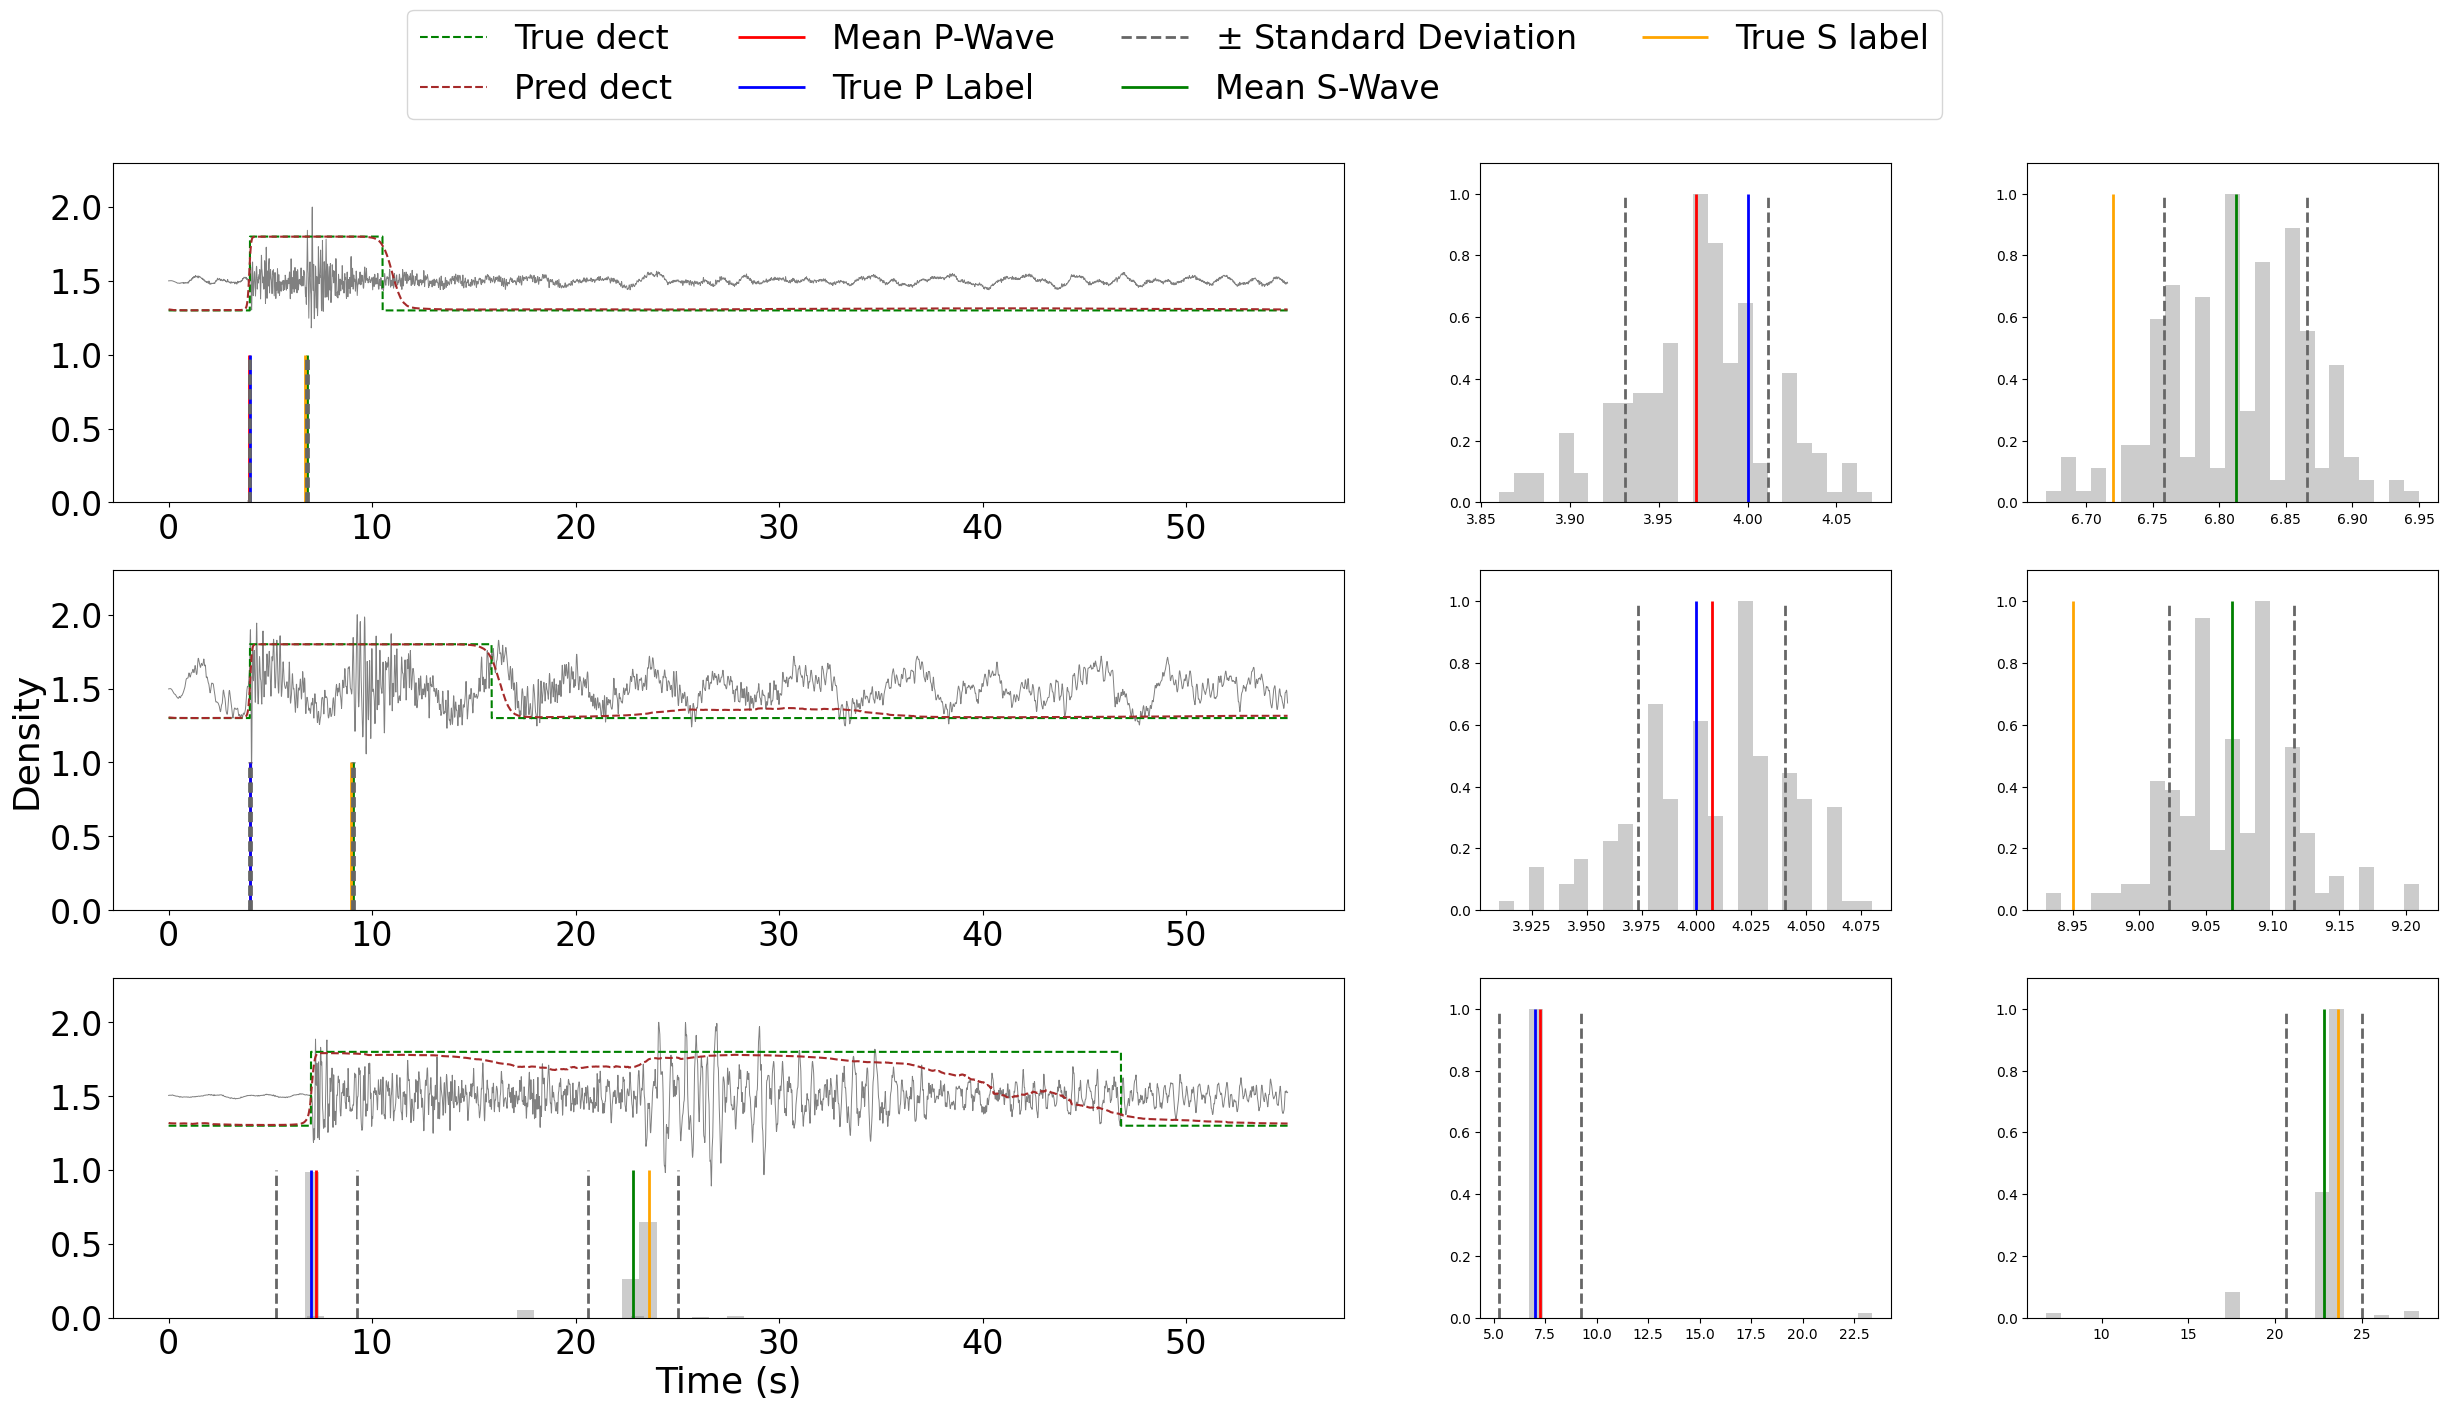

In [28]:
fig, axis = plt.subplots(3, 3, figsize=(30, 15), gridspec_kw={"width_ratios": [3, 1, 1]})

c = 0

axis[0][0].sharex(axis[1][0])
axis[1][0].sharex(axis[2][0])

axis[0][1].sharey(axis[0][2])
axis[1][1].sharey(axis[1][2])
axis[2][1].sharey(axis[2][2])

for axs, (sample_input, (preds_p, preds_s, preds_det, pred_is_p, pred_is_s, pred_is_earthquake),(true_p, true_s,true_det), snr) in zip(axis, preds):
    ax = axs[0]
    min_val = 0
    max_val = 5500

    # Plotting the wave
    x=np.array(list(range(0,6000,1)))
    if snr is str:
        split_snr = snr.replace('[', '').replace(']','').strip().split(' ')[0]
        ax.set_title(f"SNR: {split_snr}, Earthquake: {pred_is_earthquake}")
    ax.plot(x[min_val:max_val]/100, (sample_input/np.amax(sample_input)/2).T[min_val:max_val] + 1.5, color='gray', linewidth='0.7',)
    ax.plot(x[min_val:max_val]/100, true_det.T[min_val:max_val]/2 + 1.3, 'g', linestyle="--", label='True dect')
    ax.plot(x[min_val:max_val]/100, np.mean(preds_det, axis=0).T[min_val:max_val]/2 + 1.3, color='brown', linestyle="--", label='Pred dect')
    if c == 2: ax.set_xlabel('Time (s)', fontsize=26)
    if c==1: ax.set_ylabel('Density', fontsize=26)
    ax.tick_params(axis='both', which='major', labelsize=24)

    if pred_is_p:
        # Plotting the vertical lines for MAP and true label
        map_value = np.mean(preds_p)/100
        true_label = true_p
        stdP = np.std(preds_p/100)
        ax.vlines(map_value, ymax=1, ymin=0, colors="r", label="Mean P-Wave", linewidth=2)
        ax.vlines(true_label, ymax=1, ymin=0, colors="b", label="True P Label", linewidth=2)
        ax.vlines([map_value + stdP, map_value - stdP], ymax=1, ymin=0, colors="0.4", label="$\pm$ Standard Deviation", linewidth=2, linestyles="--")

        # Plotting the histogram
        n, bins, rects = ax.hist(preds_p/100, bins=25, alpha=0.4, color='gray')
        for r  in rects:
            r.set_height(r.get_height()/preds_p.shape[0])

        n, bins, rects = axs[1].hist(preds_p/100, bins=25, alpha=0.4, color='gray', density=True)

        max_height=0
        for r in rects:
            if r.get_height() > max_height:
                max_height = r.get_height()

        for r in rects:
            r.set_height(r.get_height()/max_height)

        axs[1].vlines(map_value, ymax=1, ymin=0, colors="r", label="Mean P-Wave", linewidth=2)
        axs[1].vlines(true_label, ymax=1, ymin=0, colors="b", label="True P Label", linewidth=2)
        axs[1].vlines([map_value + stdP, map_value - stdP], ymax=1, ymin=0, colors="0.4", label="$\pm$ Standard Deviation", linewidth=2, linestyles="--")
        axs[1].set_ylim(0,1.1)


    if pred_is_s:
        map_value = np.mean(preds_s)/100
        true_label = true_s
        stdS = np.std(preds_s/100)
        ax.vlines(map_value, ymax=1, ymin=0, colors="g", label="Mean S-Wave", linewidth=2)
        ax.vlines(true_label, ymax=1, ymin=0, colors="orange", label="True S label", linewidth=2)
        ax.vlines([map_value + stdS, map_value - stdS], ymax=1, ymin=0, colors="0.4", linewidth=2, linestyles="--")

        # Plotting the histogram
        n, bins, rects = ax.hist(preds_s/100, bins=25, alpha=0.4, color='gray')
        for r in rects:
            r.set_height(r.get_height()/preds_s.shape[0])

        n, bins, rects = axs[2].hist(preds_s/100, bins=25, alpha=0.4, color='gray', density=True)
        max_height=0
        for r in rects:
            if r.get_height() > max_height:
                max_height = r.get_height()

        for r in rects:
            r.set_height(r.get_height()/max_height)

        axs[2].vlines(map_value, ymax=1, ymin=0, colors="g", label="Mean S-Wave", linewidth=2)
        axs[2].vlines(true_label, ymax=1, ymin=0, colors="orange", label="True S label", linewidth=2)
        axs[2].vlines([map_value + stdS, map_value - stdS], ymax=1, ymin=0, colors="0.4", linewidth=2, linestyles="--")

        axs[2].set_ylim(0,1.1)


    # Adding legend
    if c == 0: ax.legend(fontsize=24, bbox_to_anchor=(1.5, 1.5), ncol=4)
    c += 1

    ax.set_ylim(0,2.3)

# Adjusting layout
plt.savefig("../../results/evaluation/plots/swat_uncertainty.svg")
plt.savefig("../../results/evaluation/plots/swat_uncertainty.png")
# plt.show()


In [ ]:
from swag.posteriors import SWAG

dataset = test_loader.dataset

# Load model
weights = torch.load('.cache/swag-20.pt')['state_dict']
model = SWAG(
        EQTransformer,
        no_cov_mat=True,
        max_num_models=20,
        in_channels= 1
    )
model.load_state_dict(state_dict=weights, strict=False)
model.cuda()

model.sample(0.0)

preds = predict(model, test_loader)
